In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
### ====================== RNAseq - BLOOD - Input del modelo =======================================================================================
# Leer la tabla guardada por R

bloodexpression = pd.read_csv('data/RNAseq_BLOOD.csv', index_col=0)
bloodexpression.iloc[:5, :5]


,1,2,3,9,10
GTEX-R55C-0005-SM-3GAE9.1,0.039965,0.120013,0.006625,0.098697,0.000000
GTEX-QMR6-0005-SM-32PKY.1,0.006826,0.170012,0.009171,0.002295,0.000000
GTEX-U3ZN-0006-SM-3DB7Y.1,0.086992,0.230639,0.015641,0.076125,0.002597
GTEX-WFON-0005-SM-3NMC9.1,0.098310,0.102353,0.002597,0.033602,0.000000
GTEX-14PJ4-0006-SM-7RHFY.1,0.101417,0.082130,0.012161,0.063925,0.000000


In [3]:
len(bloodexpression)

765

In [4]:
# =========== Filtrar filas que terminan en ".1", para quedarnos con 1 muestra por "paciente" ===========================
bloodexpression_1 = bloodexpression[bloodexpression.index.str.endswith(".1")]

# =========== Filtrar filas que terminan en algo distinto a ".1" ========================================================
bloodexpression_replicate = bloodexpression[~bloodexpression.index.str.endswith(".1")]

# ========= Revisión resultados =========================================================================================
print("REVISIÓN DE MUESTRAS ÚNICAS O CON REPETICIÓN")
print("Filas que terminan en .1:", len(bloodexpression_1))
print("Filas que NO terminan en .1:", len(bloodexpression_replicate))

REVISIÓN DE MUESTRAS ÚNICAS O CON REPETICIÓN
Filas que terminan en .1: 755
Filas que NO terminan en .1: 10


In [5]:
# ============== Samples repetidas (terminados en .2 y .3)
bloodexpression_not1 = bloodexpression[~bloodexpression.index.str.endswith(".1")]
len(bloodexpression_not1)
# =============== Guardar para tener a mano las replicas =================
with open("data/bloodexpression_not1.txt", "w") as f:
    for rowname in bloodexpression_not1.index:
        f.write(rowname + "\n")

In [6]:
# ======================================= HIPATHIA - RUTAS - Salida del modelo ================================================
# THYROIDE (Hipathia, rutas)
# Leer la tabla guardada por R
thyrhipathia = pd.read_csv('data/hipathia_THYR.csv', index_col=0)
thyrhipathia.iloc[:5, :5]

,P-hsa03320-37,P-hsa03320-61,P-hsa03320-46,P-hsa03320-57,P-hsa03320-64
GTEX-T5JW-1226-SM-3GACY.1,0.010343,0.015562,0.000707,0.001623,0.000000
GTEX-WXYG-0226-SM-3NB2Y.1,0.005048,0.016745,0.001547,0.003559,0.000000
GTEX-WHPG-0226-SM-3NMB9.1,0.001097,0.031996,0.002055,0.000000,0.000529
GTEX-16GPK-0926-SM-6LPJ9.1,0.007429,0.046689,0.003837,0.011437,0.003565
GTEX-183WM-2626-SM-7KFRY.1,0.035236,0.034762,0.001358,0.001803,0.001775


In [7]:
len(thyrhipathia)

653

In [8]:
# =========== Filtrar filas que terminan en ".1", para quedarnos con 1 muestra por "paciente" ===========================
thyrhipathia_1 = thyrhipathia[thyrhipathia.index.str.endswith(".1")]

# =========== Filtrar filas que terminan en algo distinto a ".1" ========================================================
thyrhipathia_replicate = thyrhipathia[~thyrhipathia.index.str.endswith(".1")]

# ========= Revisión resultados =========================================================================================
print("REVISIÓN DE MUESTRAS ÚNICAS O CON REPETICIÓN")
print("Filas que terminan en .1:", len(thyrhipathia_1))
print("Filas que NO terminan en .1:", len(thyrhipathia_replicate))

REVISIÓN DE MUESTRAS ÚNICAS O CON REPETICIÓN
Filas que terminan en .1: 653
Filas que NO terminan en .1: 0


In [9]:
# ======= Extracción de ID de paciente (los dos primeros grupos separados por "-") ======================================
bloodexpression_1 = bloodexpression_1.copy()
thyrhipathia = thyrhipathia.copy()

In [10]:
# ================================== PAREAMIENTO DE SAMPLES =============================================================
bloodexpression_1["patient_id"] = bloodexpression_1.index.str.split("-").str[0:2].str.join("-")
thyrhipathia["patient_id"] = thyrhipathia.index.str.split("-").str[0:2].str.join("-")

# ------------------- Buscar IDs de paciente en común
common_patients = set(thyrhipathia["patient_id"]) & set(bloodexpression_1["patient_id"])

In [11]:

# =====================  Filtrar solo las filas que pertenezcan a esos pacientes en ambos df ============================
bloodexpression_common = bloodexpression_1[bloodexpression_1["patient_id"].isin(common_patients)]
thyrhipathia_common = thyrhipathia[thyrhipathia["patient_id"].isin(common_patients)]
#bloodexpression_common.iloc[:5, :5]
#thyrhipathia_common.iloc[:5, :5]
print("Cantidad de samples BLOOD en común: ",len(bloodexpression_common))
print("Cantidad de samples THYR en común: ",len(thyrhipathia_common))

Cantidad de samples BLOOD en común:  522
Cantidad de samples THYR en común:  522


In [12]:
# ---------------------------- Borrar columna patient_id ---------------------------------------------------
# Blood (Genes RNAseq)
bloodexpression_common.drop(columns=['patient_id'], inplace=True)
# Thiroide (Rutas Hipathia)
thyrhipathia_common.drop(columns=['patient_id'], inplace=True)

/tmp/ipykernel_13649/1714392681.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bloodexpression_common.drop(columns=['patient_id'], inplace=True)
/tmp/ipykernel_13649/1714392681.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thyrhipathia_common.drop(columns=['patient_id'], inplace=True)


====================================================================================================
                                 
                                  CONTROL DE DATOS - BLOOD
====================================================================================================

In [13]:
# ======== Calcular varianza por columna (gen)
varianzas = bloodexpression_common.var(axis=0)
# ======== Mostrar resumen estadístico de esas varianzas
print(varianzas.describe())

count    2.318200e+04
mean     1.286731e-03
std      1.675974e-03
min      2.002447e-11
25%      2.060257e-05
50%      9.228473e-04
75%      1.936787e-03
max      3.672049e-02
dtype: float64


In [14]:
# ================ Escalar cada feature de bloodexpression_common =============================================0
# para que tenga media 0 y desviación estándar 1
pipe = Pipeline([
    ('scaler', StandardScaler())
])

In [15]:

# Eesalado y conversión de matriz numpy a DataFrame conservando estructura original
bloodexpression2 = pd.DataFrame(
    pipe.fit_transform(bloodexpression_common),
    index = bloodexpression_common.index,
    columns = bloodexpression_common.columns
)
# Creación de CSV en la carpeta datos para gaurdar los datos escalados
bloodexpression2.to_csv("data/BLOOD_EDA.csv", index=True) 


In [16]:
# Calcular varianza por columna (gen)
varianzas = bloodexpression2.var(axis=0)
# Mostrar resumen estadístico de esas varianzas
print(varianzas.describe())

count    2.318200e+04
mean     1.001919e+00
std      2.919371e-16
min      1.001919e+00
25%      1.001919e+00
50%      1.001919e+00
75%      1.001919e+00
max      1.001919e+00
dtype: float64


In [17]:
pipeMM = Pipeline([
    ('scaler', MinMaxScaler())
])
# Guardar la tabla como CSV en la carpeta datos
bloodexpression3 = pd.DataFrame(
    pipeMM.fit_transform(bloodexpression_common),
    index=bloodexpression_common.index,
    columns = bloodexpression_common.columns
)
bloodexpression3.to_csv("data/BLOOD_EDA_minmax.csv", index=True) 

In [18]:
# Calcular varianza por columna (gen)
varianzas = bloodexpression3.var(axis=0)
# Mostrar resumen estadístico de esas varianzas
print(varianzas.describe())

count    23182.000000
mean         0.023659
std          0.013053
min          0.001916
25%          0.012283
50%          0.024846
75%          0.032301
max          0.125602
dtype: float64


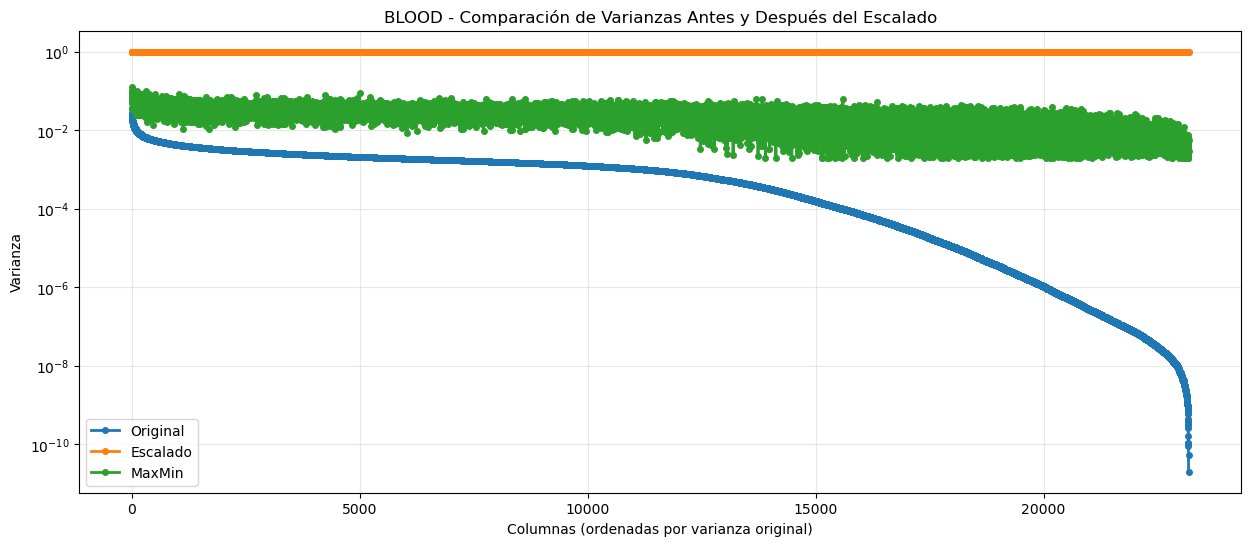

In [19]:
plt.figure(figsize=(15, 6))
varianzas_original = bloodexpression_common.var()
varianzas_escalado = bloodexpression2.var()
varianzas_maxmin = bloodexpression3.var()
# Ordenar por varianza original para mejor visualización
indices_ordenados = varianzas_original.sort_values(ascending=False).index

plt.plot(range(len(indices_ordenados)), 
         varianzas_original[indices_ordenados], 
         'o-', label='Original', linewidth=2, markersize=4)
plt.plot(range(len(indices_ordenados)), 
         varianzas_escalado[indices_ordenados], 
         'o-', label='Escalado', linewidth=2, markersize=4)
plt.plot(range(len(indices_ordenados)), 
         varianzas_maxmin[indices_ordenados], 
         'o-', label='MaxMin', linewidth=2, markersize=4)

plt.xlabel('Columnas (ordenadas por varianza original)')
plt.ylabel('Varianza')
plt.title('BLOOD - Comparación de Varianzas Antes y Después del Escalado')
plt.legend()
plt.grid(alpha=0.3)
plt.yscale('log')  # Escala logarítmica si hay mucha variación
plt.show()

/tmp/ipykernel_13649/27970758.py:4: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(datos_comparacion, labels=['Original', 'Escalado', 'MaxMin'])


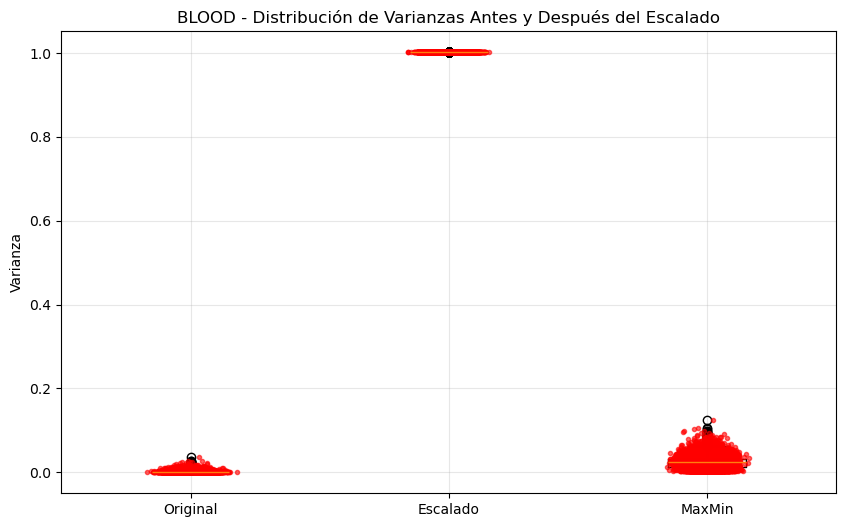

In [20]:
plt.figure(figsize=(10, 6))

datos_comparacion = [varianzas_original.values, varianzas_escalado.values, varianzas_maxmin.values]
plt.boxplot(datos_comparacion, labels=['Original', 'Escalado', 'MaxMin'])
plt.ylabel('Varianza')
plt.title('BLOOD - Distribución de Varianzas Antes y Después del Escalado')
plt.grid(alpha=0.3)

# Añadir puntos individuales
for i, datos in enumerate(datos_comparacion, 1):
    x = np.random.normal(i, 0.04, size=len(datos))
    plt.plot(x, datos, 'r.', alpha=0.6)

plt.show()

====================================================================================================
                                 
                                  CONTROL DE DATOS - THYR
====================================================================================================

In [21]:
# Calcular varianza por columna(hipathia)
varianzasthyr = thyrhipathia_common.var(axis=0)
# Mostrar resumen estadístico de esas varianzas
print(varianzasthyr.describe())

count    1.876000e+03
mean     1.367392e-04
std      3.849315e-04
min      0.000000e+00
25%      3.372408e-08
50%      5.264096e-06
75%      8.546546e-05
max      5.535265e-03
dtype: float64


In [22]:
# Si correponde
# Obtener matriz numpy (no DataFrame) con los valores escalados.
thyrhipathia2 = pd.DataFrame(
    pipe.fit_transform(thyrhipathia_common),
    index=thyrhipathia_common.index,
    columns = thyrhipathia_common.columns
)

In [23]:

# Calcular varianza por columna(hipathia)
varianzasthyr2 = thyrhipathia2.var(axis=0)
# Mostrar resumen estadístico de esas varianzas
print(varianzasthyr2.describe())

count    1876.000000
mean        1.000317
std         0.040045
min         0.000000
25%         1.001919
50%         1.001919
75%         1.001919
max         1.001919
dtype: float64


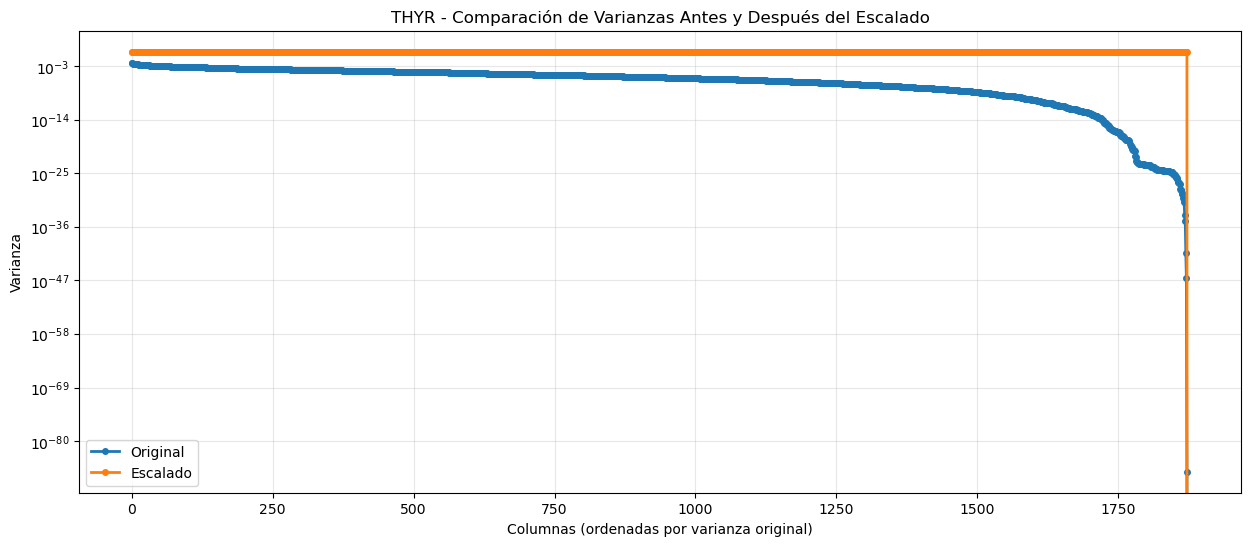

In [24]:
plt.figure(figsize=(15, 6))
varianzas_original = thyrhipathia_common.var()
varianzas_escalado = thyrhipathia2.var()
# Ordenar por varianza original para mejor visualización
indices_ordenados = varianzas_original.sort_values(ascending=False).index

plt.plot(range(len(indices_ordenados)), 
         varianzas_original[indices_ordenados], 
         'o-', label='Original', linewidth=2, markersize=4)
plt.plot(range(len(indices_ordenados)), 
         varianzas_escalado[indices_ordenados], 
         'o-', label='Escalado', linewidth=2, markersize=4)

plt.xlabel('Columnas (ordenadas por varianza original)')
plt.ylabel('Varianza')
plt.title('THYR - Comparación de Varianzas Antes y Después del Escalado')
plt.legend()
plt.grid(alpha=0.3)
plt.yscale('log')  # Escala logarítmica si hay mucha variación
plt.show()

/tmp/ipykernel_13649/3310022298.py:4: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(datos_comparacion, labels=['Original', 'Escalado'])


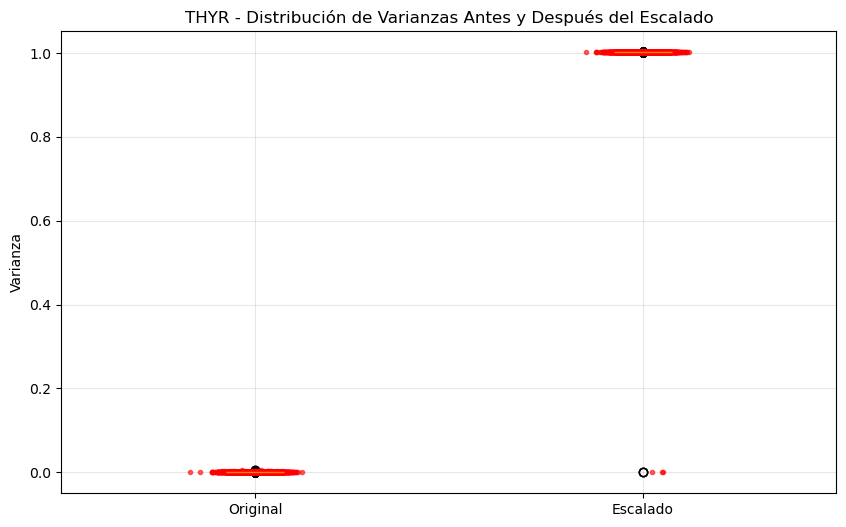

In [25]:
plt.figure(figsize=(10, 6))

datos_comparacion = [varianzas_original.values, varianzas_escalado.values]
plt.boxplot(datos_comparacion, labels=['Original', 'Escalado'])
plt.ylabel('Varianza')
plt.title('THYR - Distribución de Varianzas Antes y Después del Escalado')
plt.grid(alpha=0.3)

# Añadir puntos individuales
for i, datos in enumerate(datos_comparacion, 1):
    x = np.random.normal(i, 0.04, size=len(datos))
    plt.plot(x, datos, 'r.', alpha=0.6)

plt.show()

In [26]:

# ANÁLISIS DE VARIANZA DETALLADO

varianza_vias = thyrhipathia2.var(axis=0)

print("ESTADÍSTICAS DE VARIANZA:")
print(f"\nTotal de vías: {len(varianza_vias)}")
print(f"Varianza mínima: {varianza_vias.min()}")
print(f"Varianza máxima: {varianza_vias.max()}")
print(f"Varianza mediana: {varianza_vias.median()}")

# VALORES CONSTANTES EN TODAS LAS MUESTRAS

print("\nRUTAS CON VALORES CONSTANTES:")

vias_problematicas = []

for col in thyrhipathia2.columns:
    n_unicos = thyrhipathia2[col].nunique()
    
    if n_unicos == 1:  # Todos los valores iguales
        valor = thyrhipathia2[col].iloc[0]
        vias_problematicas.append({
            'via': col,
            'n_unicos': n_unicos,
            'valor_constante': valor,
            'varianza': varianza_vias[col]
        })

df_problematicas = pd.DataFrame(vias_problematicas)

if len(df_problematicas) > 0:
    print(f"\nVÍAS CONSTANTES DETECTADAS: {len(df_problematicas)}")
    print(df_problematicas)
else:
    print("No se encontraron vías completamente constantes")

# FILTRADO
print("\nFILTRADO DE RUTAS CON VALORES ÚNICOS")

n_unicos = thyrhipathia2.nunique()
#Filtración de rutas con mas de 5 valores únicos
thyrhipathia2_filtrado = thyrhipathia2.loc[:, (n_unicos >= 5)]

print(f"Vías originales: {thyrhipathia2.shape[1]}")
print(f"Vías filtradas: {thyrhipathia2_filtrado.shape[1]}")
print(f"Vías eliminadas: {thyrhipathia2.shape[1] - thyrhipathia2_filtrado.shape[1]}")

print("\nVías eliminadas:")
vias_eliminadas = thyrhipathia2.columns[~(n_unicos >= 5)]
for via in vias_eliminadas:
    print(f"  - {via}: var={varianza_vias[via]:.2e}, n_unicos={n_unicos[via]}")


ESTADÍSTICAS DE VARIANZA:
Total de vías: 1876

Varianza mínima: 0.0
Varianza máxima: 1.0019193857965458
Varianza mediana: 1.0019193857965452

ANÁLISIS DE VALORES ÚNICOS (detecta constantes)

VÍAS CONSTANTES DETECTADAS: 3
                via  n_unicos  valor_constante  varianza
0     P-hsa04110-46         1              0.0       0.0
1  P-hsa04218-37 38         1              0.0       0.0
2     P-hsa04960-15         1              0.0       0.0


FILTRADO DE RUTAS CON VALORES ÚNICOS
Vías originales: 1876
Vías filtradas: 1873
Vías eliminadas: 3

Vías eliminadas:
  - P-hsa04110-46: var=0.00e+00, n_unicos=1
  - P-hsa04218-37 38: var=0.00e+00, n_unicos=1
  - P-hsa04960-15: var=0.00e+00, n_unicos=1


/tmp/ipykernel_13649/1691281640.py:8: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(datos_comparacion, labels=['Original', 'Escalado', 'Filtrado'])


<Figure size 1500x600 with 0 Axes>

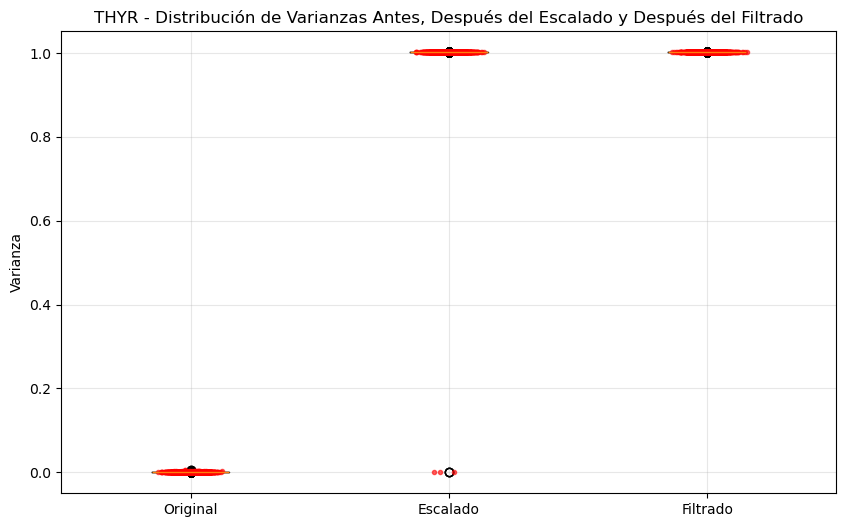

In [27]:
plt.figure(figsize=(15, 6))
varianzas_filtrado = thyrhipathia2_filtrado.var()

plt.figure(figsize=(10, 6))

datos_comparacion = [varianzas_original.values, varianzas_escalado.values, varianzas_filtrado.values]

plt.boxplot(datos_comparacion, labels=['Original', 'Escalado', 'Filtrado'])
plt.ylabel('Varianza')
plt.title('THYR - Distribución de Varianzas Antes, Después del Escalado y Después del Filtrado')
plt.grid(alpha=0.3)

# Añadir puntos individuales
for i, datos in enumerate(datos_comparacion, 1):
    x = np.random.normal(i, 0.04, size=len(datos))
    plt.plot(x, datos, 'r.', alpha=0.6)

plt.show()

In [28]:
# ================================ CORRELACIÓN =================================
# ------------------- Calculo para matriz de correlación -----------------------
corr_matrix = thyrhipathia2_filtrado.corr()

In [29]:
# Matriz de correlación básica
print("MATRIZ DE CORRELACIÓN:")
# Estadísticos descriptivos de las correlaciones
corr_values = corr_matrix.values[np.triu_indices_from(corr_matrix.values, k=1)]
print(f" Matriz de correlación: {corr_matrix.shape}")    
print(f" Número de variables: {thyrhipathia2_filtrado.shape[1]}")
print(f" Número de observaciones: {thyrhipathia2_filtrado.shape[0]}")
print(f" Rango de correlaciones: [{corr_values.min():.3f}, {corr_values.max():.3f}]")
print(f" Correlación promedio: {corr_values.mean():.3f}")
print(f" Desviación estándar: {corr_values.std():.3f}")
print(f" Correlaciones > |0.7|: {np.sum(np.abs(corr_values) > 0.7)}")
print(f" Correlaciones > |0.5|: {np.sum(np.abs(corr_values) > 0.5)}")

MATRIZ DE CORRELACIÓN:
 Matriz de correlación: (1873, 1873)
 Número de variables: 1873
 Número de observaciones: 522
 Rango de correlaciones: [-0.988, 1.000]
 Correlación promedio: 0.059
 Desviación estándar: 0.209
 Correlaciones > |0.7|: 12622
 Correlaciones > |0.5|: 58167


ANÁLISIS DE CORRELACIÓN ENTRE VÍAS

Vías altamente correlacionadas:
Pares con |r| > 0.95 : 1113 

Top 10 pares más correlacionados:
                 via1               via2  correlacion
41      P-hsa04020-64      P-hsa04020-12          1.0
44      P-hsa04020-18      P-hsa04020-17          1.0
45      P-hsa04020-18      P-hsa04020-15          1.0
46      P-hsa04020-17      P-hsa04020-15          1.0
103     P-hsa04024-31      P-hsa04024-32          1.0
188     P-hsa04066-63      P-hsa04066-57          1.0
335     P-hsa04068-47      P-hsa04068-54          1.0
370     P-hsa04068-51      P-hsa04068-56          1.0
461     P-hsa04152-33      P-hsa04922-60          1.0
529  P-hsa04510-6 4 5  P-hsa04510-26 4 5          1.0

 Estadísticas generales de correlación:
   Correlación promedio: 0.0595
   Correlación mediana: 0.0420
   Correlación máxima: 1.0000
   Correlación mínima: -0.9884
   Desviación estándar: 0.2086

Visualizaciones


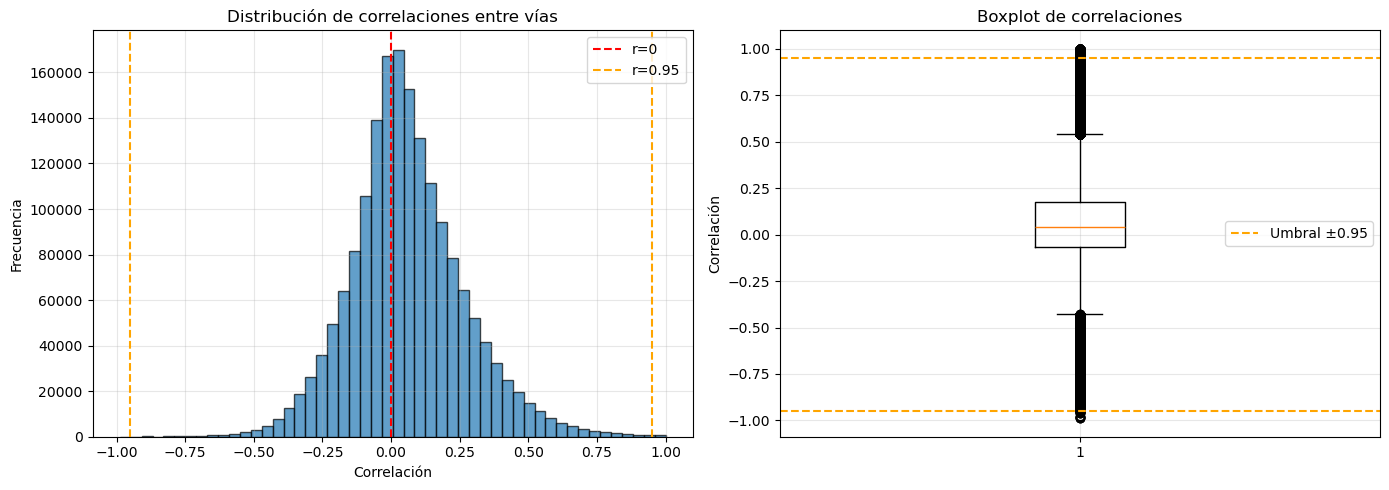

In [35]:
print("ANÁLISIS DE CORRELACIÓN ENTRE VÍAS")
# ALTA CORRELACIÓN (REDUNDANCIA)
print("\nVías altamente correlacionadas:")

# Obtener pares de vías con correlación > umbral
correlacion_alta = 0.95

# Crear una máscara para el triángulo superior (triU)
mask = np.triu(np.ones_like(corr_matrix, dtype=bool), k=1) 

# Encontrar pares altamente correlacionados
pares_alta_corr = []

for i in range(len(corr_matrix.index)):
    for j in range(i+1, len(corr_matrix.columns)):
        correlacion = corr_matrix.iloc[i, j]
        if abs(correlacion) > correlacion_alta :
            pares_alta_corr.append({
                'via1': corr_matrix.index[i],
                'via2': corr_matrix.columns[j],
                'correlacion': correlacion
            })
       
df_pares = pd.DataFrame(pares_alta_corr)   

if len(df_pares) > 0:
    print(f"Pares con |r| > {correlacion_alta} : {len(df_pares)} ")
    print("\nTop 10 pares más correlacionados:")
    print(df_pares.nlargest(10, 'correlacion')[['via1', 'via2', 'correlacion']])
else:
    print(f"No hay pares con |r| > {correlacion_alta}")

# ====================== ESTADÍSTICAS DE CORRELACIÓN =======================================
print("\nEstadísticas generales de correlación:")

# Obtener solo el triángulo superior (sin diagonal)
corr_values = corr_matrix.where(mask).stack().values

print(f"   Correlación promedio: {np.mean(corr_values):.4f}")
print(f"   Correlación mediana: {np.median(corr_values):.4f}")
print(f"   Correlación máxima: {np.max(corr_values):.4f}")
print(f"   Correlación mínima: {np.min(corr_values):.4f}")
print(f"   Desviación estándar: {np.std(corr_values):.4f}")

# ======================= HISTOGRAMA DE CORRELACIONES ======================================
print("\nVisualizaciones")

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histograma
axes[0].hist(corr_values, bins=50, edgecolor='black', alpha=0.7)
axes[0].axvline(x=0, color='red', linestyle='--', label='r=0')
axes[0].axvline(x=correlacion_alta, color='orange', linestyle='--', label=f'r={correlacion_alta}')
axes[0].axvline(x=-correlacion_alta, color='orange', linestyle='--')
axes[0].set_xlabel('Correlación')
axes[0].set_ylabel('Frecuencia')
axes[0].set_title('Distribución de correlaciones entre vías')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Boxplot
axes[1].boxplot(corr_values, vert=True)
axes[1].set_ylabel('Correlación')
axes[1].set_title('Boxplot de correlaciones')
axes[1].axhline(y=correlacion_alta, color='orange', linestyle='--', label=f'Umbral ±{correlacion_alta}')
axes[1].axhline(y=-correlacion_alta, color='orange', linestyle='--')
axes[1].grid(alpha=0.3)
axes[1].legend()

plt.tight_layout()
plt.savefig('data/imagen/correlacion_vias_histograma.png', dpi=300, bbox_inches='tight')
plt.show()

In [38]:

# ================= VÍAS REDUNDANTES A ELIMINAR ===============================================
print("\nVías a Eliminar")

# ELiminación de una de las dos vías redundantes
vias_a_eliminar = set()

if len(df_pares) > 0:
    df_pares_sorted = df_pares.sort_values('correlacion', ascending=False)
    for _, row in df_pares_sorted.iterrows():
        via1, via2 = row['via1'], row['via2']
        
        # Si ninguna de las dos está ya marcada para eliminar
        if via1 not in vias_a_eliminar and via2 not in vias_a_eliminar:
            # Eliminar la segunda (arbitrariamente)
            vias_a_eliminar.add(via2)
    
    print(f"Vías candidatas a eliminar: {len(vias_a_eliminar)}")
    # Filtración de las vías
    thyrhipathia2_reducido = thyrhipathia2_filtrado.drop(columns=list(vias_a_eliminar))
    
    print(f"\nDataset original: {thyrhipathia2_filtrado.shape[1]} vías")
    print(f"Dataset reducido: {thyrhipathia2_reducido.shape[1]} vías")
    print(f"Reducción: {len(vias_a_eliminar)} vías ({len(vias_a_eliminar)/thyrhipathia2_filtrado.shape[1]*100:.1f}%)")
else:
    print("No hay vías redundantes que eliminar")
    thyrhipathia2_reducido = thyrhipathia2_filtrado.copy()

print(f"\nDATOS FINALES")
print(f"  - {thyrhipathia2_reducido.shape[1]} vías")
print(f"  - {thyrhipathia2_reducido.shape[0]} muestras")



Vías a Eliminar
Vías candidatas a eliminar: 370

Dataset original: 1873 vías
Dataset reducido: 1503 vías
Reducción: 370 vías (19.8%)

DATOS FINALES
  - 1503 vías
  - 522 muestras


In [39]:
thyrhipathia2_reducido.to_csv("data/THYR_EDA.csv", index=True) 